In [1]:
import torch
from torch import nn

from torch.utils.data.dataset import Dataset

import os
import torch
import torch.nn.functional as F
import fnmatch
import numpy as np
import random


class RandomScaleCrop(object):
    def __init__(self, scale=[1.0, 1.2, 1.5]):
        self.scale = scale

    def __call__(self, img, label, depth, normal):
        height, width = img.shape[-2:]
        sc = self.scale[random.randint(0, len(self.scale) - 1)]
        h, w = int(height / sc), int(width / sc)
        i = random.randint(0, height - h)
        j = random.randint(0, width - w)
        img_ = F.interpolate(img[None, :, i:i + h, j:j + w], size=(height, width), mode='bilinear', align_corners=True).squeeze(0)
        label_ = F.interpolate(label[None, None, i:i + h, j:j + w], size=(height, width), mode='nearest').squeeze(0).squeeze(0)
        depth_ = F.interpolate(depth[None, :, i:i + h, j:j + w], size=(height, width), mode='nearest').squeeze(0)
        normal_ = F.interpolate(normal[None, :, i:i + h, j:j + w], size=(height, width), mode='bilinear', align_corners=True).squeeze(0)
        return img_, label_, depth_ / sc, normal_


class NYUv2(Dataset):
    """
    We could further improve the performance with the data augmentation of NYUv2 defined in:
        [1] PAD-Net: Multi-Tasks Guided Prediction-and-Distillation Network for Simultaneous Depth Estimation and Scene Parsing
        [2] Pattern affinitive propagation across depth, surface normal and semantic segmentation
        [3] Mti-net: Multiscale task interaction networks for multi-task learning

        1. Random scale in a selected raio 1.0, 1.2, and 1.5.
        2. Random horizontal flip.

    Please note that: all baselines and MTAN did NOT apply data augmentation in the original paper.
    """
    def __init__(self, root, train=True, augmentation=False):
        self.train = train
        self.root = os.path.expanduser(root)
        self.augmentation = augmentation

        # read the data file
        if train:
            self.data_path = root + '/train'
        else:
            self.data_path = root + '/val'

        # calculate data length
        self.data_len = len(fnmatch.filter(os.listdir(self.data_path + '/image'), '*.npy'))

    def __getitem__(self, index):
        # load data from the pre-processed npy files
        image = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/image/{:d}.npy'.format(index)), -1, 0))
        semantic = torch.from_numpy(np.load(self.data_path + '/label/{:d}.npy'.format(index)))
        depth = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/depth/{:d}.npy'.format(index)), -1, 0))
        normal = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/normal/{:d}.npy'.format(index)), -1, 0))

        # apply data augmentation if required
        if self.augmentation:
            image, semantic, depth, normal = RandomScaleCrop()(image, semantic, depth, normal)
            if torch.rand(1) < 0.5:
                image = torch.flip(image, dims=[2])
                semantic = torch.flip(semantic, dims=[1])
                depth = torch.flip(depth, dims=[2])
                normal = torch.flip(normal, dims=[2])
                normal[0, :, :] = - normal[0, :, :]

        return image.float(), semantic.float(), depth.float(), normal.float()

    def __len__(self):
        return self.data_len

import matplotlib.pyplot as plt
import numpy as np
ds = NYUv2(root=r"C:\Users\neetm\Desktop\DL\mtan\nyu\nyuv2", train=False)
len(ds)

654

In [ ]:
class Segnet2(nn.Module):

    def __init__(self):
        super(Segnet2, self).__init__()
        self._encoder = models.vgg16(pretrained=True).features
        self.upsample = nn.ConvTranspose2d(in_channels=512, out_channels=256, )

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import os

"""
Define task metrics, loss functions and model trainer here.
"""


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def model_fit(x_pred, x_output, task_type):
    device = x_pred.device

    # binary mark to mask out undefined pixel space
    binary_mask = (torch.sum(x_output, dim=1) != 0).float().unsqueeze(1).to(device)

    if task_type == 'semantic':
        # semantic loss: depth-wise cross entropy
        loss = F.nll_loss(x_pred, x_output, ignore_index=-1)

    if task_type == 'depth':
        # depth loss: l1 norm
        loss = torch.sum(torch.abs(x_pred - x_output) * binary_mask) / torch.nonzero(binary_mask, as_tuple=False).size(0)

    if task_type == 'normal':
        # normal loss: dot product
        loss = 1 - torch.sum((x_pred * x_output) * binary_mask) / torch.nonzero(binary_mask, as_tuple=False).size(0)

    return loss

class ConfMatrix(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mat = None

    def update(self, pred, target):
        n = self.num_classes
        if self.mat is None:
            self.mat = torch.zeros((n, n), dtype=torch.int64, device=pred.device)
        with torch.no_grad():
            k = (target >= 0) & (target < n)
            inds = n * target[k].to(torch.int64) + pred[k]
            self.mat += torch.bincount(inds, minlength=n ** 2).reshape(n, n)

    def get_metrics(self):
        h = self.mat.float()
        acc = torch.diag(h).sum() / h.sum()
        iu = torch.diag(h) / (h.sum(1) + h.sum(0) - torch.diag(h))
        return torch.mean(iu).item(), acc.item()


def depth_error(x_pred, x_output):
    device = x_pred.device
    binary_mask = (torch.sum(x_output, dim=1) != 0).unsqueeze(1).to(device)
    x_pred_true = x_pred.masked_select(binary_mask)
    x_output_true = x_output.masked_select(binary_mask)
    abs_err = torch.abs(x_pred_true - x_output_true)
    rel_err = torch.abs(x_pred_true - x_output_true) / x_output_true
    return (torch.sum(abs_err) / torch.nonzero(binary_mask, as_tuple=False).size(0)).item(), \
           (torch.sum(rel_err) / torch.nonzero(binary_mask, as_tuple=False).size(0)).item()


def normal_error(x_pred, x_output):
    binary_mask = (torch.sum(x_output, dim=1) != 0)
    error = torch.acos(torch.clamp(torch.sum(x_pred * x_output, 1).masked_select(binary_mask), -1, 1)).detach().cpu().numpy()
    error = np.degrees(error)
    return np.mean(error), np.median(error), np.mean(error < 11.25), np.mean(error < 22.5), np.mean(error < 30)


"""
=========== Universal Multi-task Trainer =========== 
"""


def multi_task_trainer(train_loader, test_loader, multi_task_model, device, optimizer, scheduler, opt, total_epoch=200):
    train_batch = len(train_loader)
    test_batch = len(test_loader)
    T = opt.temp
    avg_cost = np.zeros([total_epoch, 24], dtype=np.float32)
    lambda_weight = np.ones([3, total_epoch])
    for index in range(total_epoch):
        cost = np.zeros(24, dtype=np.float32)

        # apply Dynamic Weight Average
        if opt.weight == 'dwa':
            if index == 0 or index == 1:
                lambda_weight[:, index] = 1.0
            else:
                w_1 = avg_cost[index - 1, 0] / avg_cost[index - 2, 0]
                w_2 = avg_cost[index - 1, 3] / avg_cost[index - 2, 3]
                w_3 = avg_cost[index - 1, 6] / avg_cost[index - 2, 6]
                lambda_weight[0, index] = 3 * np.exp(w_1 / T) / (np.exp(w_1 / T) + np.exp(w_2 / T) + np.exp(w_3 / T))
                lambda_weight[1, index] = 3 * np.exp(w_2 / T) / (np.exp(w_1 / T) + np.exp(w_2 / T) + np.exp(w_3 / T))
                lambda_weight[2, index] = 3 * np.exp(w_3 / T) / (np.exp(w_1 / T) + np.exp(w_2 / T) + np.exp(w_3 / T))

        # iteration for all batches
        multi_task_model.train()
        train_dataset = iter(train_loader)
        conf_mat = ConfMatrix(13)
        for k in range(train_batch):
            train_data, train_label, train_depth, train_normal = train_dataset.next()
            train_data, train_label = train_data.to(device), train_label.long().to(device)
            train_depth, train_normal = train_depth.to(device), train_normal.to(device)

            train_pred, logsigma = multi_task_model(train_data)

            optimizer.zero_grad()
            train_loss = [model_fit(train_pred[0], train_label, 'semantic'),
                          model_fit(train_pred[1], train_depth, 'depth'),
                          model_fit(train_pred[2], train_normal, 'normal')]

            if opt.weight == 'equal' or opt.weight == 'dwa':
                loss = sum([lambda_weight[i, index] * train_loss[i] for i in range(3)])
            else:
                loss = sum(1 / (2 * torch.exp(logsigma[i])) * train_loss[i] + logsigma[i] / 2 for i in range(3))

            loss.backward()
            optimizer.step()

            # accumulate label prediction for every pixel in training images
            conf_mat.update(train_pred[0].argmax(1).flatten(), train_label.flatten())

            cost[0] = train_loss[0].item()
            cost[3] = train_loss[1].item()
            cost[4], cost[5] = depth_error(train_pred[1], train_depth)
            cost[6] = train_loss[2].item()
            cost[7], cost[8], cost[9], cost[10], cost[11] = normal_error(train_pred[2], train_normal)
            avg_cost[index, :12] += cost[:12] / train_batch

        # compute mIoU and acc
        avg_cost[index, 1:3] = np.array(conf_mat.get_metrics())

        # evaluating test data
        multi_task_model.eval()
        conf_mat = ConfMatrix(13)
        with torch.no_grad():  # operations inside don't track history
            test_dataset = iter(test_loader)
            for k in range(test_batch):
                test_data, test_label, test_depth, test_normal = test_dataset.next()
                test_data, test_label = test_data.to(device), test_label.long().to(device)
                test_depth, test_normal = test_depth.to(device), test_normal.to(device)

                test_pred, _ = multi_task_model(test_data)
                test_loss = [model_fit(test_pred[0], test_label, 'semantic'),
                             model_fit(test_pred[1], test_depth, 'depth'),
                             model_fit(test_pred[2], test_normal, 'normal')]

                conf_mat.update(test_pred[0].argmax(1).flatten(), test_label.flatten())

                cost[12] = test_loss[0].item()
                cost[15] = test_loss[1].item()
                cost[16], cost[17] = depth_error(test_pred[1], test_depth)
                cost[18] = test_loss[2].item()
                cost[19], cost[20], cost[21], cost[22], cost[23] = normal_error(test_pred[2], test_normal)
                avg_cost[index, 12:] += cost[12:] / test_batch

            # compute mIoU and acc
            avg_cost[index, 13:15] = np.array(conf_mat.get_metrics())

        scheduler.step()
        print('Epoch: {:04d} | TRAIN: {:.4f} {:.4f} {:.4f} | {:.4f} {:.4f} {:.4f} | {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} ||'
            'TEST: {:.4f} {:.4f} {:.4f} | {:.4f} {:.4f} {:.4f} | {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} '
            .format(index, avg_cost[index, 0], avg_cost[index, 1], avg_cost[index, 2], avg_cost[index, 3],
                    avg_cost[index, 4], avg_cost[index, 5], avg_cost[index, 6], avg_cost[index, 7], avg_cost[index, 8],
                    avg_cost[index, 9], avg_cost[index, 10], avg_cost[index, 11], avg_cost[index, 12], avg_cost[index, 13],
                    avg_cost[index, 14], avg_cost[index, 15], avg_cost[index, 16], avg_cost[index, 17], avg_cost[index, 18],
                    avg_cost[index, 19], avg_cost[index, 20], avg_cost[index, 21], avg_cost[index, 22], avg_cost[index, 23]))

        if index%5==0:
            state_dict = {"model_state_dict":multi_task_model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "epoch": index, "loss": avg_cost}
            torch.save(state_dict, os.path.join(opt.ckpt_dir, f"model_epoch_{index}.pth"))
"""
=========== Universal Single-task Trainer =========== 
"""


def single_task_trainer(train_loader, test_loader, single_task_model, device, optimizer, scheduler, task, ckpt_dir, total_epoch=200):
    train_batch = len(train_loader)
    test_batch = len(test_loader)
    avg_cost = np.zeros([total_epoch, 24], dtype=np.float32)
    for index in range(total_epoch):
        cost = np.zeros(24, dtype=np.float32)

        # iteration for all batches
        single_task_model.train()
        train_dataset = iter(train_loader)
        conf_mat = ConfMatrix(13)
        for k in range(train_batch):
            train_data, train_label, train_depth, train_normal = train_dataset.next()
            train_data, train_label = train_data.to(device), train_label.long().to(device)
            train_depth, train_normal = train_depth.to(device), train_normal.to(device)

            train_pred = single_task_model(train_data)
            optimizer.zero_grad()

            if task == 'semantic':
                train_loss = model_fit(train_pred, train_label, task)
                train_loss.backward()
                optimizer.step()

                conf_mat.update(train_pred.argmax(1).flatten(), train_label.flatten())
                cost[0] = train_loss.item()

            if task == 'depth':
                train_loss = model_fit(train_pred, train_depth, task)
                train_loss.backward()
                optimizer.step()
                cost[3] = train_loss.item()
                cost[4], cost[5] = depth_error(train_pred, train_depth)

            if task == 'normal':
                train_loss = model_fit(train_pred, train_normal, task)
                train_loss.backward()
                optimizer.step()
                cost[6] = train_loss.item()
                cost[7], cost[8], cost[9], cost[10], cost[11] = normal_error(train_pred, train_normal)

            avg_cost[index, :12] += cost[:12] / train_batch

        if task == 'semantic':
            avg_cost[index, 1:3] = np.array(conf_mat.get_metrics())

        # evaluating test data
        single_task_model.eval()
        conf_mat = ConfMatrix(13)
        with torch.no_grad():  # operations inside don't track history
            test_dataset = iter(test_loader)
            for k in range(test_batch):
                test_data, test_label, test_depth, test_normal = test_dataset.next()
                test_data, test_label = test_data.to(device),  test_label.long().to(device)
                test_depth, test_normal = test_depth.to(device), test_normal.to(device)

                test_pred = single_task_model(test_data)

                if task == 'semantic':
                    test_loss = model_fit(test_pred, test_label, task)

                    conf_mat.update(test_pred.argmax(1).flatten(), test_label.flatten())
                    cost[12] = test_loss.item()

                if task == 'depth':
                    test_loss = model_fit(test_pred, test_depth, task)
                    cost[15] = test_loss.item()
                    cost[16], cost[17] = depth_error(test_pred, test_depth)

                if task == 'normal':
                    test_loss = model_fit(test_pred, test_normal, task)
                    cost[18] = test_loss.item()
                    cost[19], cost[20], cost[21], cost[22], cost[23] = normal_error(test_pred, test_normal)

                avg_cost[index, 12:] += cost[12:] / test_batch
            if task == 'semantic':
                avg_cost[index, 13:15] = np.array(conf_mat.get_metrics())

        scheduler.step()
        if task == 'semantic':
            print('Epoch: {:04d} | TRAIN: {:.4f} {:.4f} {:.4f} TEST: {:.4f} {:.4f} {:.4f}'
              .format(index, avg_cost[index, 0], avg_cost[index, 1], avg_cost[index, 2], avg_cost[index, 12], avg_cost[index, 13], avg_cost[index, 14]))
        if task == 'depth':
            print('Epoch: {:04d} | TRAIN: {:.4f} {:.4f} {:.4f} TEST: {:.4f} {:.4f} {:.4f}'
              .format(index, avg_cost[index, 3], avg_cost[index, 4], avg_cost[index, 5], avg_cost[index, 15], avg_cost[index, 16], avg_cost[index, 17]))
        if task == 'normal':
            print('Epoch: {:04d} | TRAIN: {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} TEST: {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'
              .format(index, avg_cost[index, 6], avg_cost[index, 7], avg_cost[index, 8], avg_cost[index, 9], avg_cost[index, 10], avg_cost[index, 11],
                      avg_cost[index, 18], avg_cost[index, 19], avg_cost[index, 20], avg_cost[index, 21], avg_cost[index, 22], avg_cost[index, 23]))

        
        if index%5==0:
            state_dict = {"model_state_dict":single_task_model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "epoch": index, "loss": avg_cost}
            torch.save(state_dict, os.path.join(ckpt_dir, f"model_epoch_{index}.pth"))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models.vgg import VGG
import torch.nn.functional as F

class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output


ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


class FCN8s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
        score = self.bn2(score + x3)                      # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score) 
        score = F.log_softmax(score, dim=1)                   # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)

In [ ]:
model = VGGNet()
model2 = FCN8s(model, 13).cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(model2.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
nyuv2_test_set = NYUv2(root=r"C:\Users\neetm\Desktop\DL\mtan\nyu\nyuv2", train=False)
nyuv2_train_set = NYUv2(root=r"C:\Users\neetm\Desktop\DL\mtan\nyu\nyuv2", train=True, augmentation=True)
batch_size = 4
nyuv2_train_loader = torch.utils.data.DataLoader(
    dataset=nyuv2_train_set,
    batch_size=batch_size,
    shuffle=True)

nyuv2_test_loader = torch.utils.data.DataLoader(
    dataset=nyuv2_test_set,
    batch_size=batch_size,
    shuffle=False)

In [ ]:
single_task_trainer(nyuv2_train_loader,
                    nyuv2_test_loader,
                    model2,
                    device,
                    optimizer,
                    scheduler,
                    'semantic',
                    r"C:\Users\neetm\Desktop\DL\MultiNet2-A-Multitask_leraning-architecture\ckpt_dir",
                    200)


In [20]:
import torchvision.models as models

model = models.alexnet(True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\neetm/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [02:02<00:00, 1.99MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
from torchvision.ops import roi_align

x = ds[0][0].unsqueeze(0)

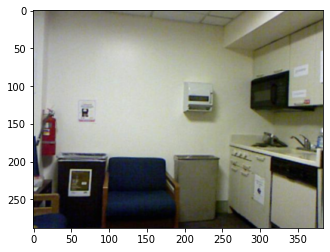

In [9]:
import matplotlib.pyplot as plt

plt.imshow(x[0].permute(1,2,0))